In [17]:
# all imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump, load
import matplotlib.pyplot as plt
import imblearn.over_sampling 
from imblearn.over_sampling import SMOTE

import sys
import warnings

# Get rid of warnings
warnings.filterwarnings('ignore')

# read data in
df = pd.read_csv('./online_shoppers_intention.csv')

In [18]:
# iteration without TrafficType and Region as they have lowest pearson correlation to Revenue
categorical_features = ['OperatingSystems', 'Browser', 'VisitorType', 'Weekend', 'Month']
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

transformers = [
    ('one_hot', OneHotEncoder(), categorical_features),
    ('robustscale', RobustScaler(), numerical_features),  # Or RobustScaler() as needed
    ('minscale', MinMaxScaler(), numerical_features)  # Or MinMaxScaler() as needed
]

preprocessor = ColumnTransformer(transformers=transformers)

# Drop unnecessary categories in training data
x = df.drop(['Revenue', 'Region', 'TrafficType'], axis=1) 
y = df['Revenue'].astype(int) # Target


# Apply transformations
x_preproc = preprocessor.fit_transform(x)

# Splitting the dataset into develop data and final validation comparison
x_dev, x_val, y_dev, y_val = train_test_split(x_preproc, y, test_size=0.1, random_state=42)

# Apply SMOTE algorithm to even out amount of data for development for purchases to no purchases
print("Development Set Revenue Freq: ")
print(y_dev.value_counts(), "\n")
smo = SMOTE()
x_os, y_os = smo.fit_resample(x_dev, y_dev)
print("Oversampled Development Data Revenue Freq: ")
print(y_os.value_counts(), "\n")

# Splitting the dataset into training and testing sets after preprocessing all data
x_train, x_test, y_train, y_test = train_test_split(x_os, y_os, test_size=0.2, random_state=42)

Development Set Revenue Freq: 
Revenue
0    9392
1    1705
Name: count, dtype: int64 

Oversampled Development Data Revenue Freq: 
Revenue
0    9392
1    9392
Name: count, dtype: int64 



In [19]:
# Create a random forest classifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5)

# Fit the classifier to the training data
random_forest.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = random_forest.predict(x_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Test Data:", accuracy)
# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_train, random_forest.predict(x_train))
print("Accuracy Train Data:", accuracy)

Accuracy Test Data: 0.8687782805429864
Accuracy Train Data: 0.8774871897251614


In [20]:
# params to evaluate
param_distributions = {
    'n_estimators': [200, 180, 150],
    'max_depth': [24, 20, 16]  # epochs
}

rf_grids = RandomForestClassifier(random_state=42)

# set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_distributions, scoring=['accuracy'], refit='accuracy', cv=25, verbose=2)

# run the grid search
grid_search.fit(x_dev, y_dev)

# report best
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_  

# Accuracy given by positive number
best_params, best_accuracy

Fitting 25 folds for each of 9 candidates, totalling 225 fits
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=24, n_e

({'max_depth': 20, 'n_estimators': 180}, 0.9051981778618348)

In [22]:
# test against validation data for final comparison
y_pred_val = grid_search.best_estimator_.predict(x_val)

# Print out all metrics for final validatino; mainly accuracy, f1-score, TPR, FPR 
accuracy_val = accuracy_score(y_val, y_pred_val)
print('GridSearchCV Accuracy Validation: %.3f' % (accuracy_val * 100), '%')
print(classification_report(y_val, y_pred_val))
metrics_results = classification_report(y_val, y_pred_val, output_dict = True)
print('F1-Score: ', metrics_results['macro avg']['f1-score'], '\n')
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val, labels=[0, 1]).ravel()
print(confusion_matrix(y_val, y_pred_val))
print('True Positive Rate: ', tp/(tp + fn))
print('False Positive Rate: ', fp/(fp + tn))

GridSearchCV Accuracy Validation: 89.132 %
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1030
           1       0.71      0.57      0.63       203

    accuracy                           0.89      1233
   macro avg       0.82      0.76      0.78      1233
weighted avg       0.88      0.89      0.89      1233

F1-Score:  0.7840596606058071 

[[984  46]
 [ 88 115]]
True Positive Rate:  0.5665024630541872
False Positive Rate:  0.04466019417475728


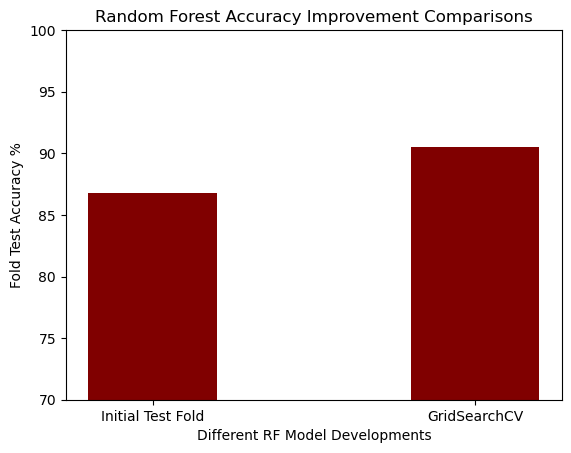

In [23]:
# Print the bar plot for accuracy comparisons with each trial of different appraoch to retrieving model
test_accuracies = [86.78, 90.52]
categories =['Initial Test Fold', 'GridSearchCV']
# creating the bar plot
plt.bar(categories, test_accuracies, color ='maroon', 
        width = 0.4)
plt.ylim(70, 100) 
plt.xlabel("Different RF Model Developments")
plt.ylabel("Fold Test Accuracy %")
plt.title("Random Forest Accuracy Improvement Comparisons")
plt.show()

In [24]:
# Save the model
dump(rf_grids, 'rf_model.joblib')

['rf_model.joblib']